# A Causal Inference Study on the Impact of Higher Education on Salaries

### Seunghyun Park
### 260686853





In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)


warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings(action='ignore', category=UserWarning,
                        message='.*No further splits with positive gain.*')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/IBM_Employee.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


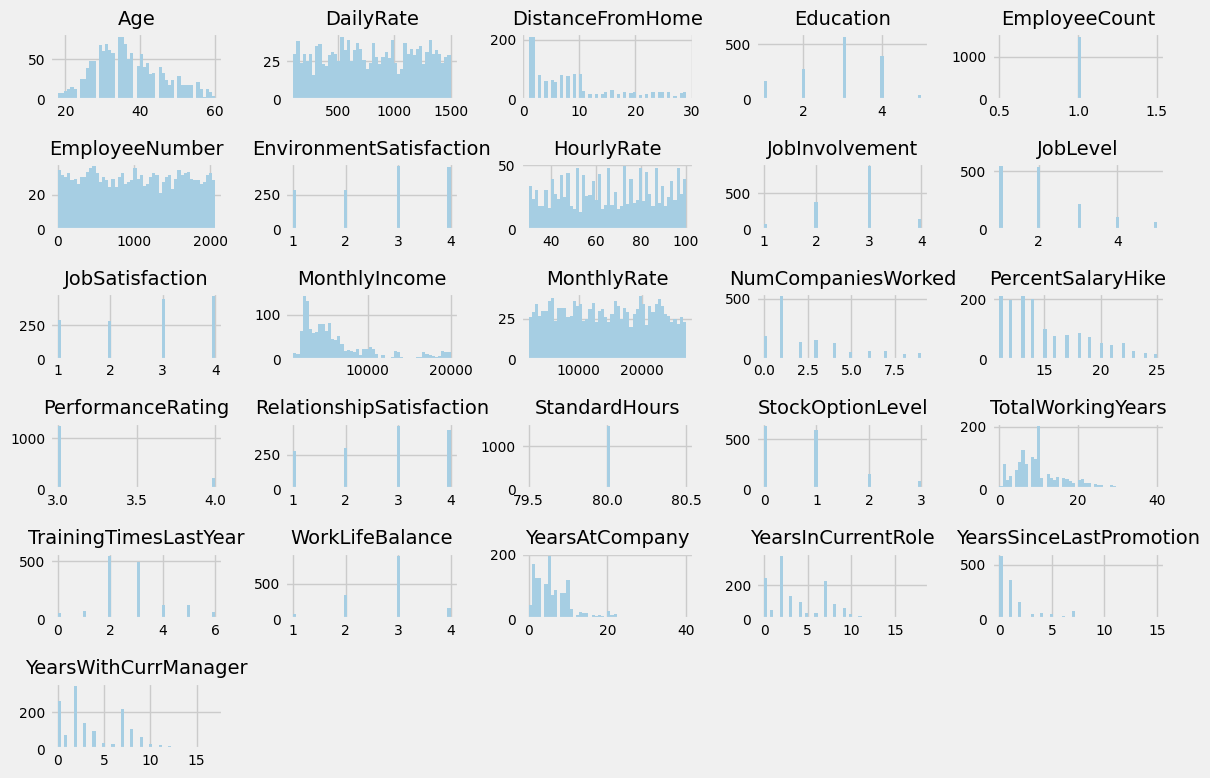

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


df.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

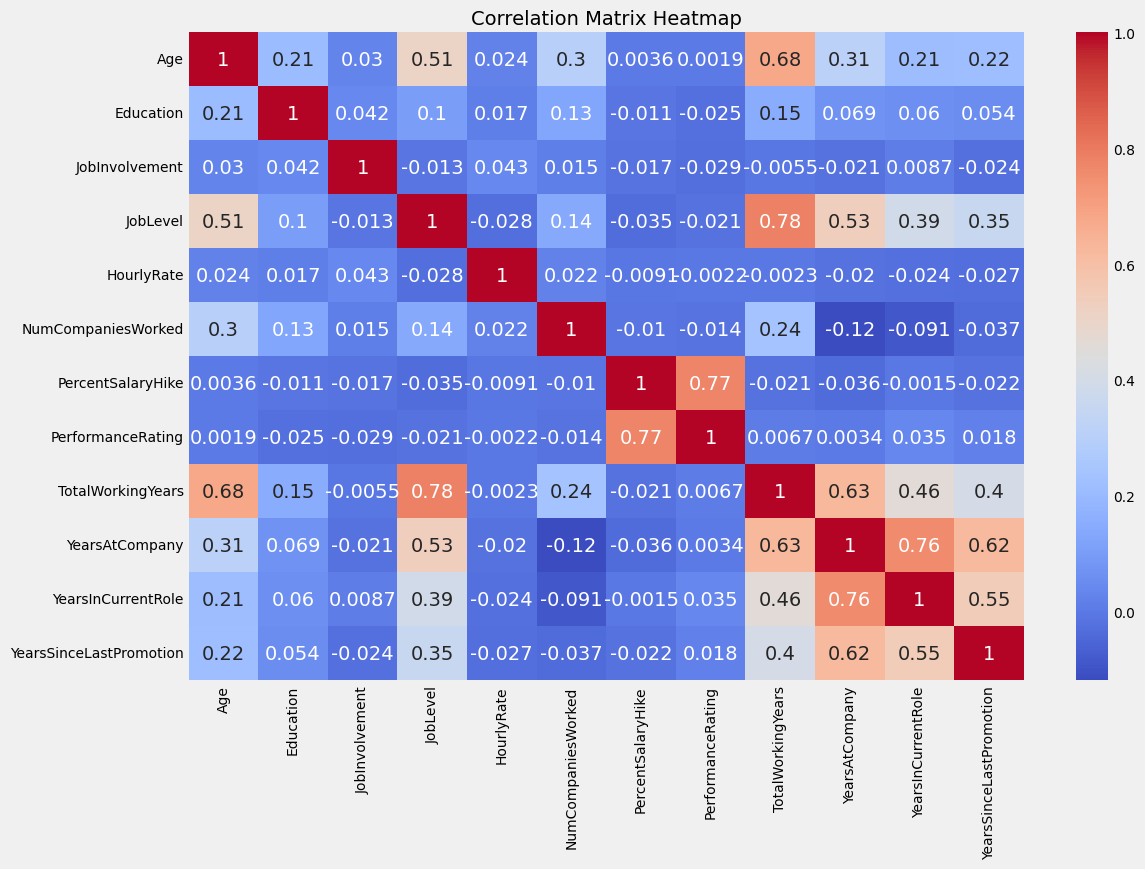

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df[['Age', 'Education','JobInvolvement', 'JobLevel','HourlyRate',
                  'NumCompaniesWorked','PercentSalaryHike','PerformanceRating',
                  'TotalWorkingYears','YearsAtCompany','YearsInCurrentRole',
                  'YearsSinceLastPromotion']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

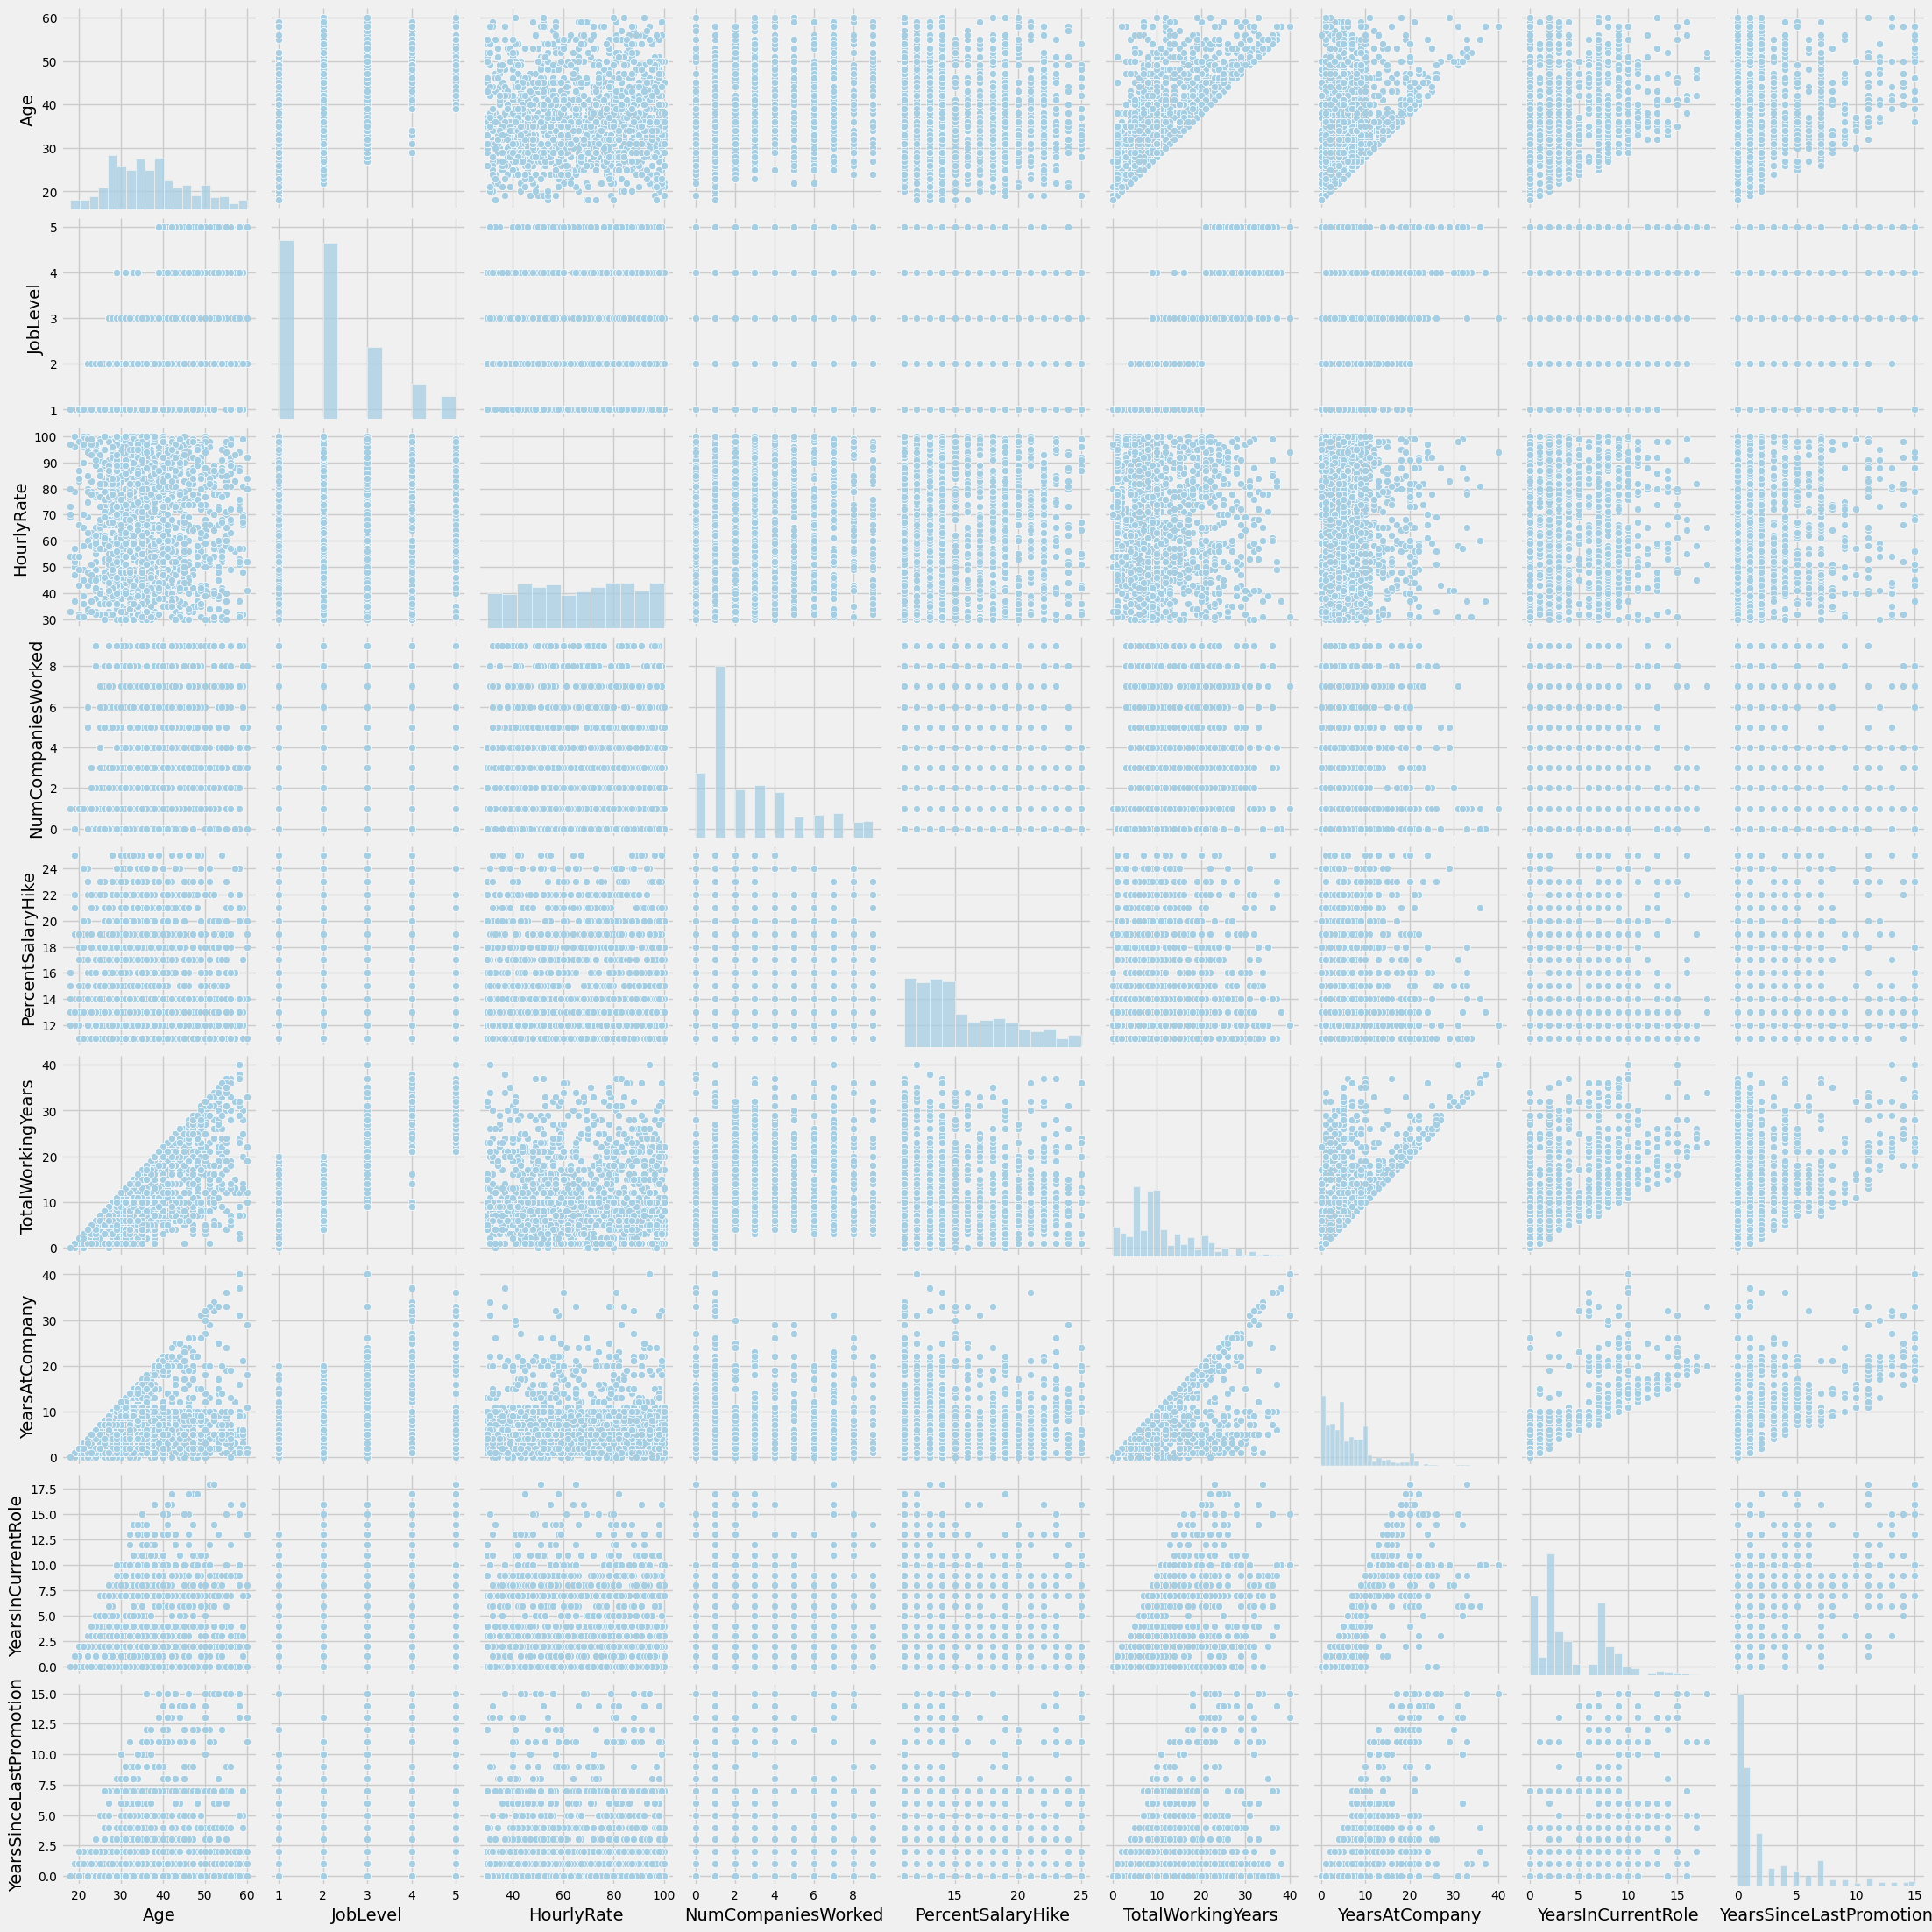

In [ ]:
sns.pairplot(df[['Age','JobLevel', 'HourlyRate','NumCompaniesWorked',
                 'PercentSalaryHike', 'TotalWorkingYears','YearsAtCompany',
                 'YearsInCurrentRole','YearsSinceLastPromotion']])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/IBM_Employee.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=815)
outlier_pred = isolation_forest.fit_predict(df[['Age', 'Education',
                                                'JobInvolvement','HourlyRate',
                                                'NumCompaniesWorked',
                                                'PercentSalaryHike','PerformanceRating',
                                                'TotalWorkingYears','YearsAtCompany',
                                                'YearsInCurrentRole','YearsSinceLastPromotion']])



In [ ]:
print(len(df))
df = df[outlier_pred == 1]
print(len(df))


1470
1087


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['EducationField_encoded'] = label_encoder.fit_transform(df['EducationField'])
df['Department_encoded'] = label_encoder.fit_transform(df['Department'])
df['Gender_encoded'] = label_encoder.fit_transform(df['Gender'])
df['OverTime_Encoded'] = label_encoder.fit_transform(df['OverTime'])


In [ ]:
df = df.dropna(subset=['Education'])

In [ ]:
df['Education'].value_counts()

3    454
4    291
2    211
1    108
5     23
Name: Education, dtype: int64

In [ ]:
df['Treatment'] = df['Education'].map({
    1: -1,
    2: -1,
    3: 0,
    4: 1,
    5: 1,
})
df = df[(df['Treatment'] == 1) | (df['Treatment'] == 0)]

In [ ]:
df['Treatment'].value_counts()

0    454
1    314
Name: Treatment, dtype: int64

In [ ]:
import pandas as pd
from sklearn.utils import resample


treatment = df[df['Treatment'] == 1]
control = df[df['Treatment'] == 0]

control_undersampled = resample(control,
                                replace=False,
                                n_samples=len(treatment),
                                random_state=950815)

df_balanced = pd.concat([control_undersampled, treatment])

df = df_balanced.sample(frac=1, random_state=950815).reset_index(drop=True)


In [ ]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='HourlyRate',
               index='Treatment',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,HourlyRate,HourlyRate
Treatment,,
0,65.585987,314
1,65.783439,314
All,65.684713,628


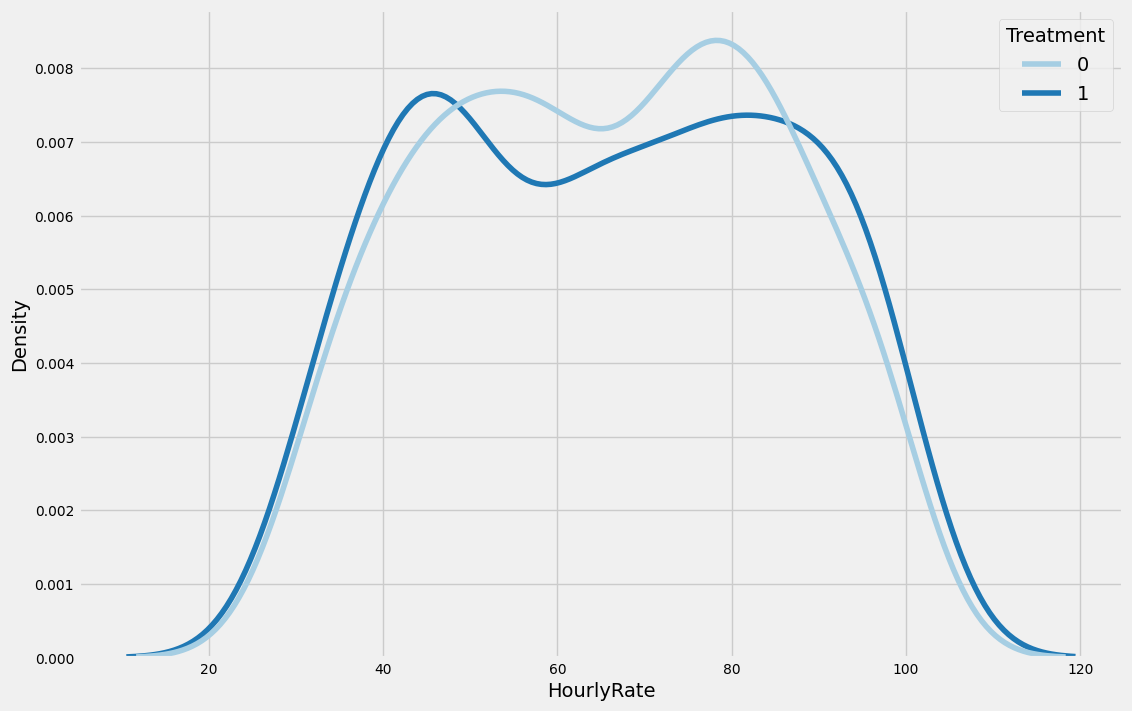

In [ ]:
sns.kdeplot(data=df, x='HourlyRate', hue='Treatment')
plt.show()

# Calculate the Average Treatment Effect (ATE)


In [ ]:
y_train = df['HourlyRate']
treatment_train = df['Treatment']
X_train = df[['Age','JobInvolvement','NumCompaniesWorked',
              'PercentSalaryHike','EducationField_encoded','Department_encoded',
              'Gender_encoded','OverTime_Encoded',
                  'PerformanceRating','TotalWorkingYears','YearsAtCompany',
              'YearsInCurrentRole','YearsSinceLastPromotion']]


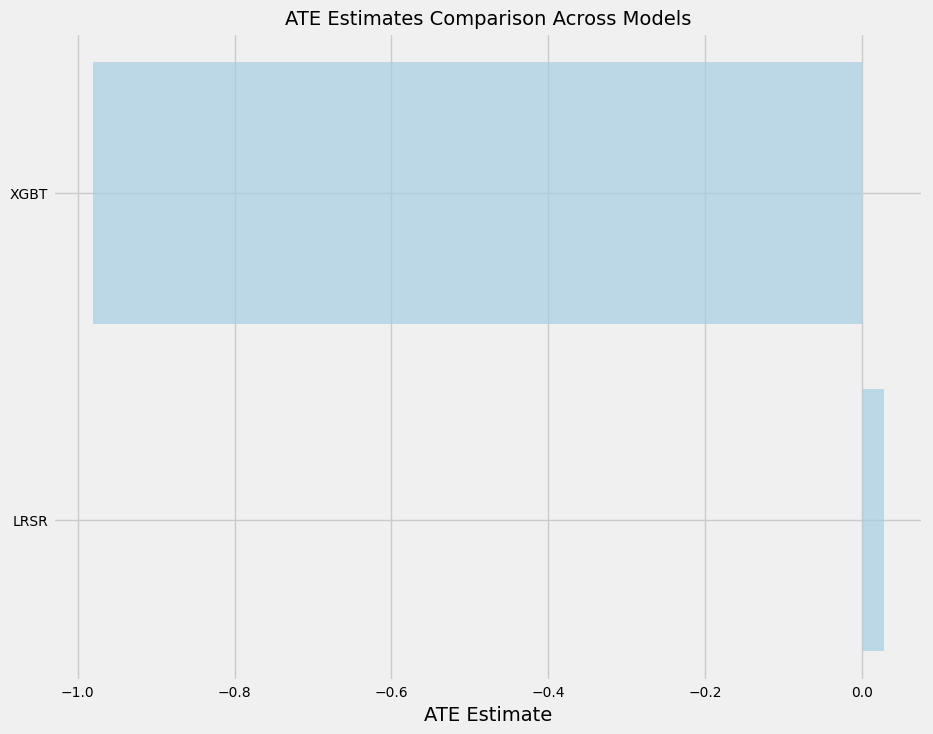

In [ ]:
from sklearn.model_selection import train_test_split


p_model = ElasticNetPropensityModel()
e = p_model.fit_predict(X_train, treatment_train)

# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s_linear = learner_s.estimate_ate(X=X_train,
                                      treatment=treatment_train, y=y_train)

learner_s =XGBTRegressor()
ate_s_XGBT = learner_s.estimate_ate(X=X_train,
                                    treatment=treatment_train, y=y_train)
import matplotlib.pyplot as plt
import numpy as np


ate_estimates = {
    'LRSR': ate_s_linear[0][0],
    'XGBT': ate_s_XGBT[0][0]
}


plt.figure(figsize=(10, 8))
models = list(ate_estimates.keys())
ate_values = [ate_estimates[model] for model in models]
y_pos = np.arange(len(models))

plt.barh(y_pos, ate_values, align='center', alpha=0.7)
plt.yticks(y_pos, models)
plt.xlabel('ATE Estimate')
plt.title('ATE Estimates Comparison Across Models')

plt.show()

In [ ]:
print(ate_s_XGBT[0][0])
print(ate_s_linear[0][0])

-0.9807840456628496
0.027840497386809382


In [ ]:


# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t_XGBR = learner_t.estimate_ate(X=X_train,
                                    treatment=treatment_train, y=y_train)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t_linear = learner_t.estimate_ate(X=X_train,
                                      treatment=treatment_train, y=y_train)


# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x_XGBR_p = learner_x.estimate_ate(X=X_train,
                                      treatment=treatment_train, y=y_train, p=e)


# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x_linear_p= learner_x.estimate_ate(X=X_train,
                                       treatment=treatment_train, y=y_train, p=e)


# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x_XGBR = learner_x.estimate_ate(X=X_train,
                                    treatment=treatment_train, y=y_train)


# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x_linear = learner_x.estimate_ate(X=X_train,
                                      treatment=treatment_train, y=y_train)


# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r_XGBR_p = learner_r.estimate_ate(X=X_train,
                                      treatment=treatment_train, y=y_train, p=e)


# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r_linear_p = learner_r.estimate_ate(X=X_train,
                                        treatment=treatment_train, y=y_train, p=e)


# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y_train))
ate_r_XGBR_p_weight = learner_r.estimate_ate(X=X_train,
                                             treatment=treatment_train,
                                             y=y_train, p=e, sample_weight=sample_weight)

# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in linear regression
learner_r = BaseRRegressor(learner=LinearRegression())
sample_weight = np.random.randint(1, 3, len(y_train))
ate_r_linear_p_weight = learner_r.estimate_ate(X=X_train,
                                               treatment=treatment_train,
                                               y=y_train, p=e, sample_weight=sample_weight)


# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r_XGBR = learner_r.estimate_ate(X=X_train, treatment=treatment_train, y=y_train)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r_linear = learner_r.estimate_ate(X=X_train, treatment=treatment_train, y=y_train)


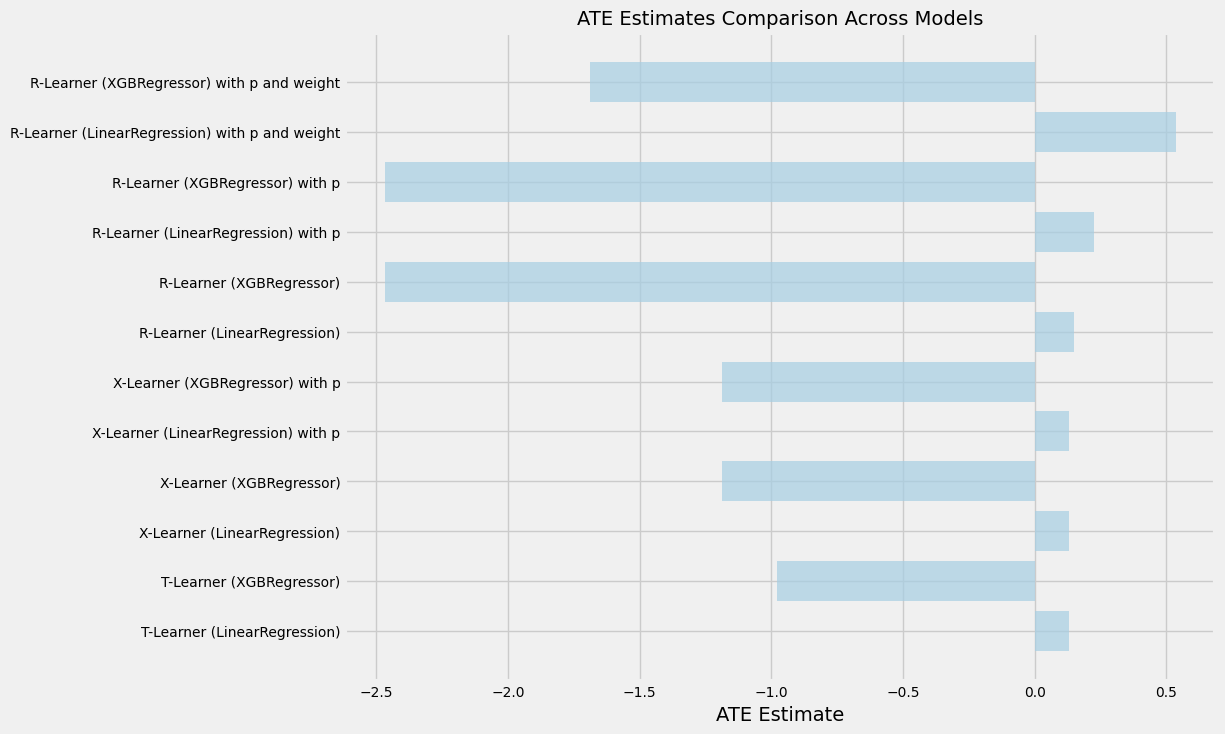

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ate_estimates = {
    'T-Learner (LinearRegression)': ate_t_linear[0][0],
    'T-Learner (XGBRegressor)': ate_t_XGBR[0][0],
    'X-Learner (LinearRegression)': ate_x_linear[0][0],
    'X-Learner (XGBRegressor)': ate_x_XGBR[0][0],
    'X-Learner (LinearRegression) with p': ate_x_linear[0][0],
    'X-Learner (XGBRegressor) with p': ate_x_XGBR[0][0],
    'R-Learner (LinearRegression)': ate_r_linear[0][0],
    'R-Learner (XGBRegressor)': ate_r_XGBR_p[0][0],
    'R-Learner (LinearRegression) with p': ate_r_linear_p[0][0],
    'R-Learner (XGBRegressor) with p': ate_r_XGBR_p[0][0],
    'R-Learner (LinearRegression) with p and weight': ate_r_linear_p_weight[0][0],
    'R-Learner (XGBRegressor) with p and weight': ate_r_XGBR_p_weight[0][0]
}

plt.figure(figsize=(10, 8))
models = list(ate_estimates.keys())
ate_values = [ate_estimates[model] for model in models]
y_pos = np.arange(len(models))

plt.barh(y_pos, ate_values, align='center', alpha=0.7)
plt.yticks(y_pos, models)
plt.xlabel('ATE Estimate')
plt.title('ATE Estimates Comparison Across Models')

plt.show()

# Calculate Individual Treatment Effect (ITE/CATE)


In [ ]:
# S Learner
p_model = ElasticNetPropensityModel()
e = p_model.fit_predict(X_train, treatment_train)

learner_s = LRSRegressor()
cate_s_linear = learner_s.fit_predict(X=X_train,
                                      treatment=treatment_train, y=y_train)

learner_s = XGBTRegressor()
cate_s_XGBT = learner_s.fit_predict(X=X_train,
                                    treatment=treatment_train, y=y_train)


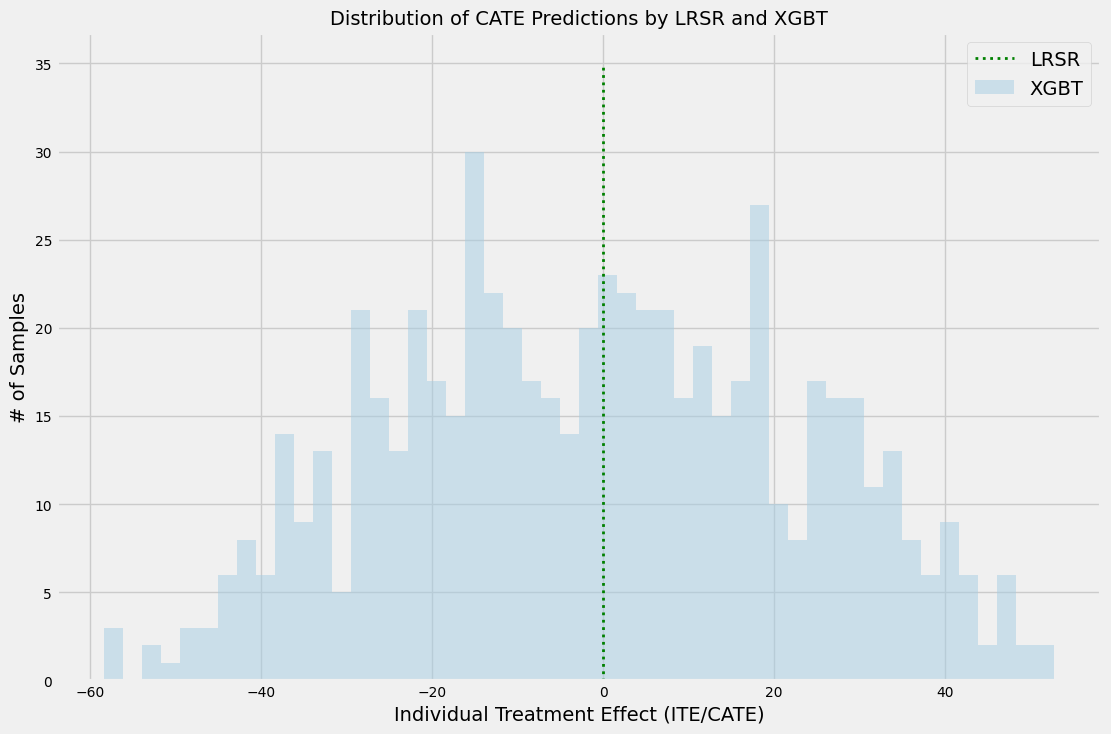

In [ ]:
alpha= 0.5
bins=50
plt.figure(figsize=(12,8))
plt.vlines(cate_s_linear[0], 0, 35, label='LRSR',
           linestyles='dotted', colors='green', linewidth=2)
plt.hist(cate_s_XGBT, alpha=alpha, bins=bins, label='XGBT')

plt.title('Distribution of CATE Predictions by LRSR and XGBT')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')

_=plt.legend()

In [ ]:
# S Learner
p_model = ElasticNetPropensityModel()
e = p_model.fit_predict(X_train, treatment_train)


# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t_XGBR = learner_t.fit_predict(X=X_train,
                                    treatment=treatment_train, y=y_train)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
cate_t_linear = learner_t.fit_predict(X=X_train,
                                      treatment=treatment_train, y=y_train)


# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x_XGBR_p = learner_x.fit_predict(X=X_train,
                                      treatment=treatment_train, y=y_train, p=e)


# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
cate_x_linear_p = learner_x.fit_predict(X=X_train,
                                        treatment=treatment_train, y=y_train, p=e)


# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
cate_x_XGBR = learner_x.fit_predict(X=X_train,
                                    treatment=treatment_train, y=y_train)


# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
cate_x_linear = learner_x.fit_predict(X=X_train,
                                      treatment=treatment_train, y=y_train)


# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r_XGBR_p = learner_r.fit_predict(X=X_train,
                                      treatment=treatment_train, y=y_train, p=e)


# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
cate_r_linear_p = learner_r.fit_predict(X=X_train,
                                        treatment=treatment_train, y=y_train, p=e)


# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y_train))
cate_r_XGBR_p_weight = learner_r.fit_predict(X=X_train,
                                             treatment=treatment_train,
                                             y=y_train, p=e, sample_weight=sample_weight)

# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in linear regression
learner_r = BaseRRegressor(learner=LinearRegression())
sample_weight = np.random.randint(1, 3, len(y_train))
cate_r_linear_p_weight = learner_r.fit_predict(X=X_train,
                                               treatment=treatment_train,
                                               y=y_train, p=e, sample_weight=sample_weight)


# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r_XGBR = learner_r.fit_predict(X=X_train, treatment=treatment_train, y=y_train)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
cate_r_linear = learner_r.fit_predict(X=X_train, treatment=treatment_train, y=y_train)


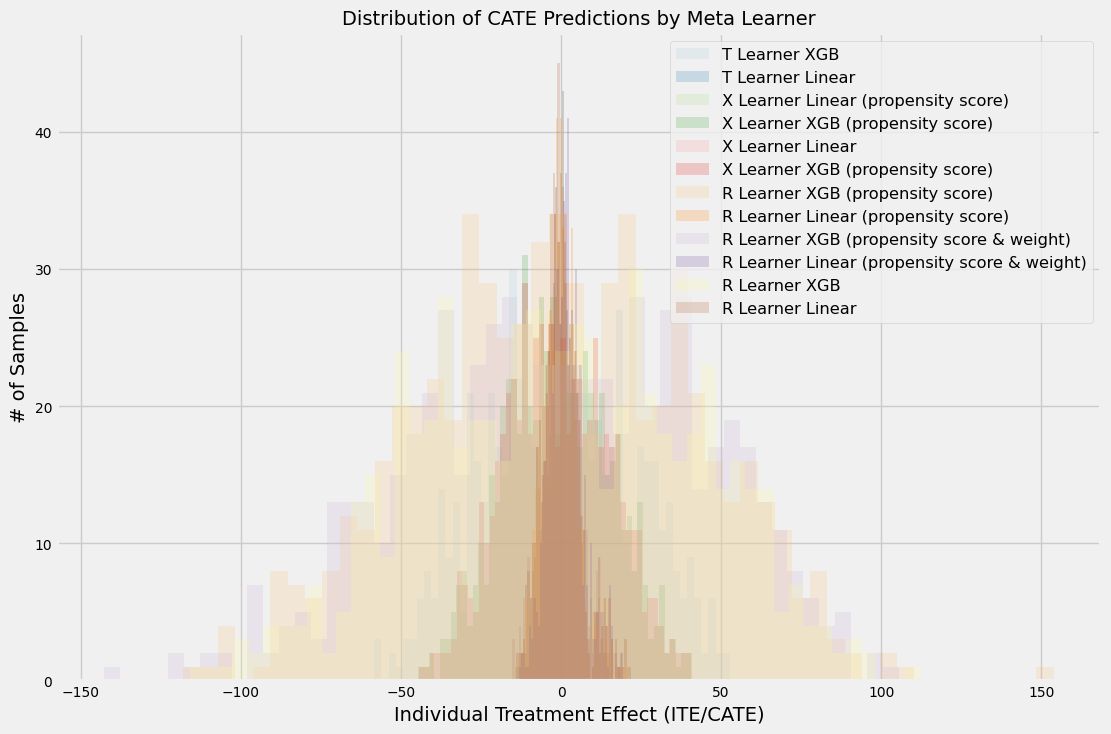

In [ ]:
alpha= 0.2
bins=50
plt.figure(figsize=(12,8))

plt.hist(cate_t_XGBR, alpha=alpha, bins=bins, label='T Learner XGB')

plt.hist(cate_t_linear, alpha=alpha, bins=bins, label='T Learner Linear')

plt.hist(cate_x_linear_p, alpha=alpha, bins=bins, label='X Learner Linear (propensity score)')

plt.hist(cate_x_XGBR_p, alpha=alpha, bins=bins, label='X Learner XGB (propensity score)')
plt.hist(cate_x_linear, alpha=alpha, bins=bins, label='X Learner Linear')

plt.hist(cate_x_XGBR, alpha=alpha, bins=bins, label='X Learner XGB (propensity score)')

plt.hist(cate_r_XGBR_p, alpha=alpha, bins=bins, label='R Learner XGB (propensity score)')

plt.hist(cate_r_linear_p, alpha=alpha, bins=bins, label='R Learner Linear (propensity score)')

plt.hist(cate_r_XGBR_p_weight, alpha=alpha, bins=bins,
         label='R Learner XGB (propensity score & weight)')
plt.hist(cate_r_linear_p_weight, alpha=alpha, bins=bins,
         label='R Learner Linear (propensity score & weight)')
plt.hist(cate_r_XGBR, alpha=alpha, bins=bins, label='R Learner XGB')
plt.hist(cate_r_linear, alpha=alpha, bins=bins, label='R Learner Linear')


plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')

plt.legend(fontsize='small')

# Feature Importance

## Feature Importance (LRSRegressor)

In [ ]:

feature_names=['Age','JobInvolvement','NumCompaniesWorked',
               'PercentSalaryHike','EducationField_encoded','Department_encoded',
               'Gender_encoded','OverTime_Encoded',
                  'PerformanceRating','TotalWorkingYears',
               'YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion']

In [ ]:
slearner = LRSRegressor(control_name=1)

slearner.estimate_ate(X_train, treatment_train, y_train)
slearner_tau = slearner.fit_predict(X_train, treatment_train, y_train)
slearner.get_importance(X=X_train,
                        tau=slearner_tau,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{0: Age                       NaN
 JobInvolvement            NaN
 NumCompaniesWorked        NaN
 PercentSalaryHike         NaN
 EducationField_encoded    NaN
 Department_encoded        NaN
 Gender_encoded            NaN
 OverTime_Encoded          NaN
 PerformanceRating         NaN
 TotalWorkingYears         NaN
 YearsAtCompany            NaN
 YearsInCurrentRole        NaN
 YearsSinceLastPromotion   NaN
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

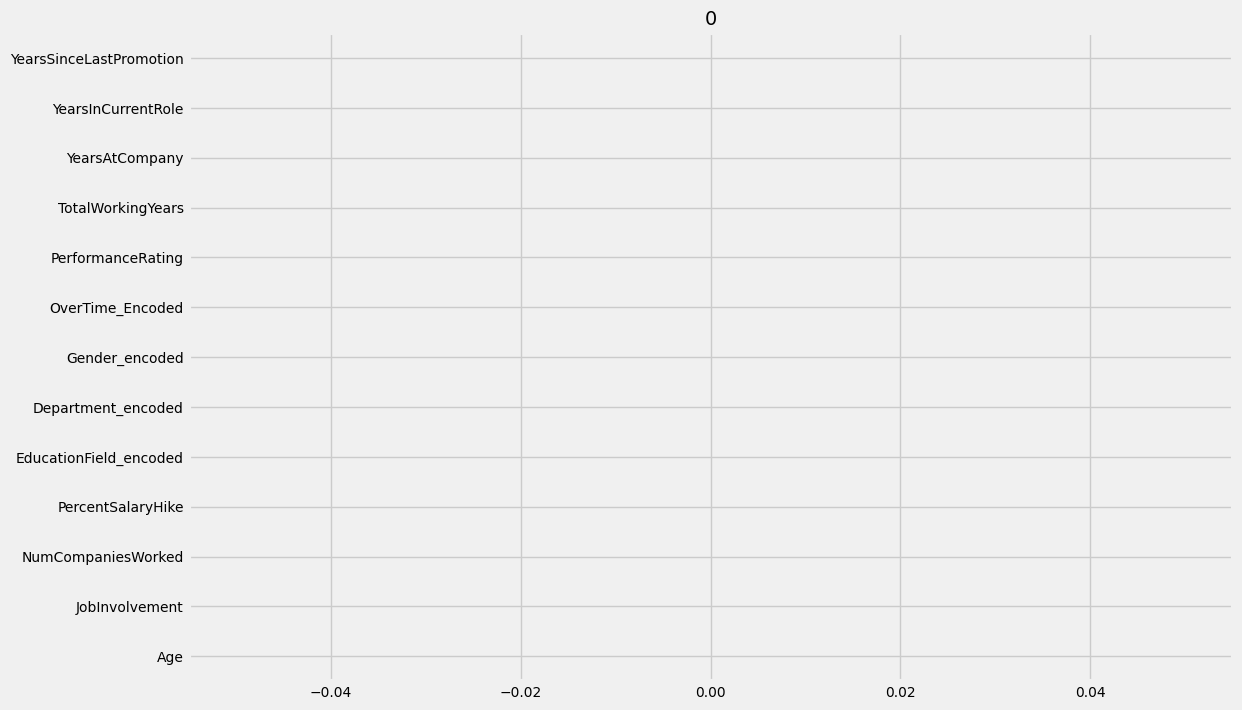

In [ ]:
slearner.plot_importance(X=X_train,
                         tau=slearner_tau,
                         normalize=True,
                         method='auto',
                         features=feature_names)

## Feature Importance (XGBTRegressor)


In [ ]:
slearner = XGBTRegressor(control = 1,verbose_eval = -1)
slearner.estimate_ate(X_train, treatment_train, y_train)
slearner_tau = slearner.fit_predict(X_train, treatment_train, y_train)
slearner.get_importance(X=X_train,
                        tau=slearner_tau,normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Age                        0.203414
 PercentSalaryHike          0.124994
 TotalWorkingYears          0.120453
 YearsAtCompany             0.089329
 YearsSinceLastPromotion    0.087052
 EducationField_encoded     0.084371
 NumCompaniesWorked         0.082039
 YearsInCurrentRole         0.074611
 Department_encoded         0.063602
 JobInvolvement             0.027720
 Gender_encoded             0.024895
 OverTime_Encoded           0.017520
 PerformanceRating          0.000000
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

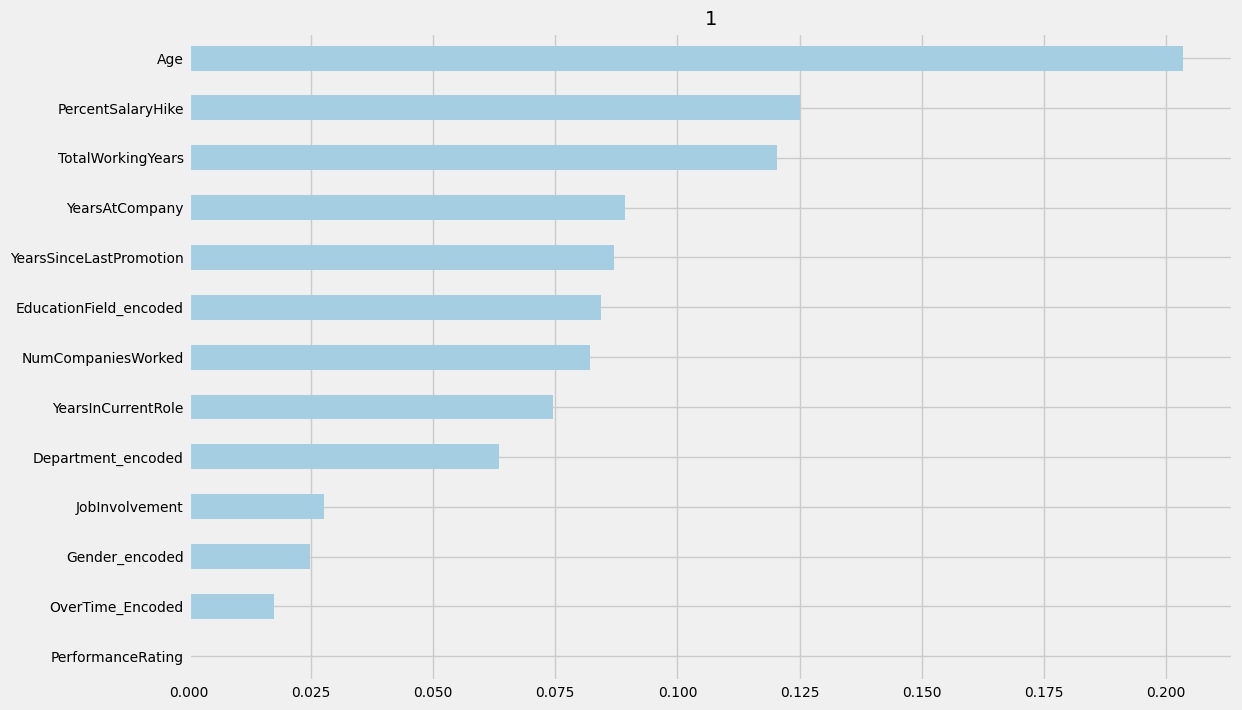

In [ ]:
slearner.plot_importance(X=X_train,
                         tau=slearner_tau,
                         method='auto', normalize=True,
                         features=feature_names)

The hypothesis of my research posits that individuals holding advanced degrees, such as Master's and Doctorates, receive higher salaries compared to their counterparts with Bachelor's degrees. To explore this, I divided employees into two groups: those with a Bachelor's degree and those with a Master's or Doctorate degree. An initial comparison of the hourly rates between these groups showed no significant differences, leading me to delve deeper using causal inference methods.

To determine the effect of higher education on salaries, I employed causalML library, focusing primarily on two regression methods: the LRSRegressor (Linear Regression) and the XGBTRegressor (XGBoost). Additionally, I explored the T-learner, X-learner, and R-learner models for a comprehensive analysis.

The Average Treatment Effect (ATE), representing the mean outcome difference between the treatment (higher education) and control groups, varied across models. The ATE from the LRSRegressor, based on a linear model, was 0.0278, while the ATE from the XGBTRegressor, which handles complex non-linear relationships more effectively, was -0.9807. These results suggest a slight influence of obtaining a Master's or Doctorate degree on salary, although the effect is relatively minor given the average hourly rate of $66. The ATE estimates from other models consistently indicated a small effect, with maximum value of -2.5. Linear model-based analysis indicated a positive impact of higher education on salaries, whereas the XGBoost model revealed a negative influence, suggesting a complex relationship between educational attainment and salary outcomes.

The analysis of the Individual Treatment Effect (ITE/CATE) using XGBT showed values clustered around zero, indicating a non-significant effect on individual level. Similarly, the LRSRegressor yielded a minor effect. There results suggest a slight influence on salary, although the impact is negligible at the individual level.

The feature importance analysis for the LRSRegressor yielded NaN (Not a Number) values for all features with warning message, 'there were no meaningful features which satisfy the provided configuration'. This unexpected outcome suggests potential challenges in the model fitting process or data compatibility with the feature importance calculation method.

 On the other hand, the XGBTRegressor identified several key factors, with 'Age' being the most significant (0.203414), followed by 'Percent Salary Hike' (0.124994), and 'Total Working Years' (0.120453). Other notable features included 'Years at Company', 'Years Since Last Promotion', and 'Education Field_encoded', among others, indicating the complex factors influencing salary beyond educational attainment.

In conclusion, although advanced degrees are commonly associated with higher earning potential, my analysis suggests that their impact on salary is minimal and that other professional and demographic factors play a more significant role. This challenges the traditional view and highlights the importance of considering a broader range of factors when evaluating the benefits of further education for career advancement.